<a href="https://colab.research.google.com/github/SatyaanikaPandam/Data-Science/blob/main/Saty_PandU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You need to submit a .ipynb file with the first four letters of one first name, the first four letters of one last name, and U5proj.

Ex.

A student named Avy Aguacate Avocado Palta will submit a file named "Avy_AvocU5proj.ipynb", since she normally just goes by Avy, and, when pressed, reports Avocado as her last name. The " _ " after "Avy" serves as the fourth "letter" in her first name.

Ex2.

Army Armadillo will submit a file named "ArmyArmaU5proj.ipynb"

In [16]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

In [17]:
#load the data into a pandas dataframe, and print it
url_iris = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/iris.csv'
#I could have put the url string directly into pd.read_csv()
iris = pd.read_csv(url_iris)


In [18]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


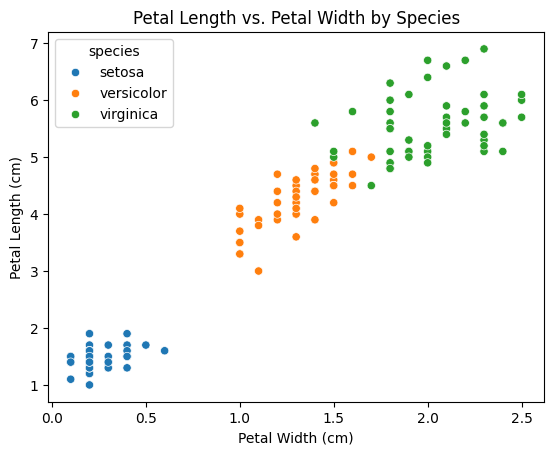

In [19]:
# @title Petal Length vs. Petal Width by Species

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'iris' is your DataFrame
sns.scatterplot(x='petal_width', y='petal_length', hue='species', data=iris)
plt.xlabel('Petal Width (cm)')
plt.ylabel('Petal Length (cm)')
_ = plt.title('Petal Length vs. Petal Width by Species')

<Axes: xlabel='petal_width', ylabel='petal_length'>

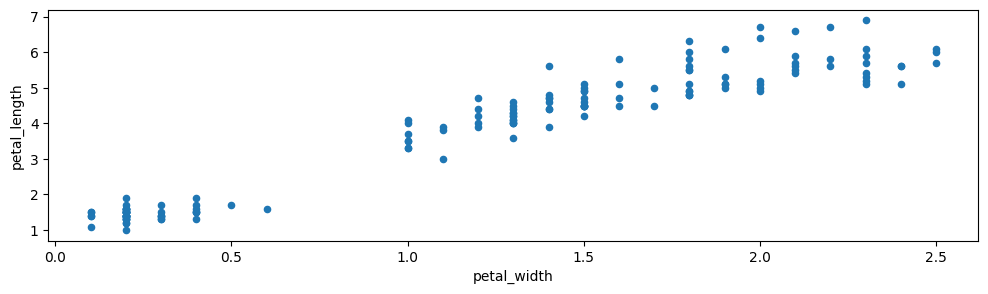

In [20]:
#scatter plot of temperature v. rented count of bikes
iris.plot(x="petal_width", y="petal_length", figsize=(12, 3), kind="scatter")


In the graph above, I noticed a gap between approximately 0.5 and 1.0. At first, I wasn’t sure what it meant, but I guessed it might represent data that was difficult to find or collect. When I asked Mr. A about it, he explained using the recommended plots, which showed the three different petal species. It became clear that there was no data for any of the species in the range between 0.5 and 1.0.

In [21]:
#li stands for linear iris
with pm.Model() as model_li:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * iris.petal_width)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed= iris.petal_length)

    #inference data object
    idata_li = pm.sample()


Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

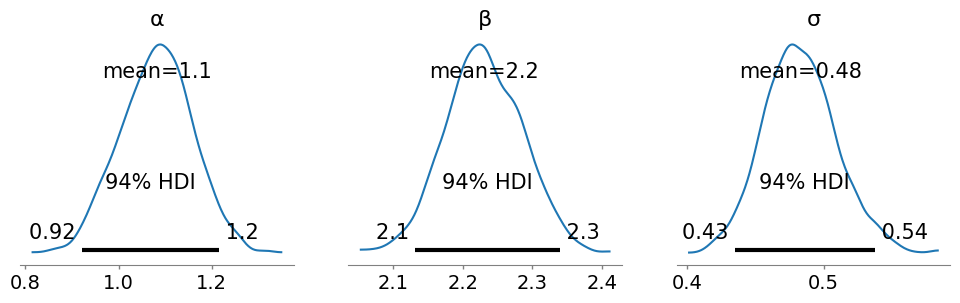

In [22]:

#plot of the posteriors for all the components of my line
#'~μ' means plot all variables except μ
az.plot_posterior(idata_li, var_names=["~μ"], figsize=(12, 3))


Text(0, 0.5, 'petal length')

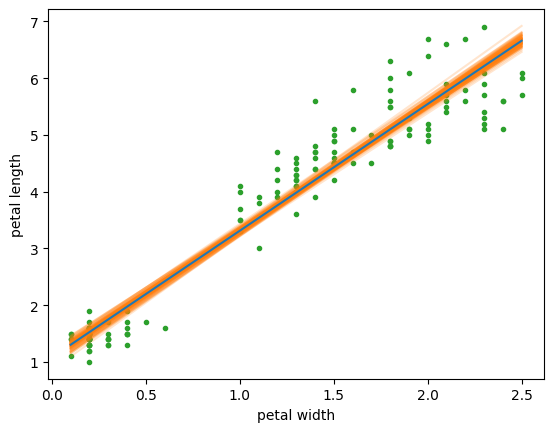

In [23]:

#grabs 100 posterior samples
posterior = az.extract(idata_li, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(iris.petal_width.min(), iris.petal_width.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(iris.petal_width, iris.petal_length, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("petal width")
ax.set_ylabel("petal length")



The graph shows how petal width and petal length are related. The dark orange line is the model's best fit line, showing what the model expects the data to look like if the relationship is truly a straight line. The lighter orange lines are extra lines that show other possible fits based on the model's uncertainty. Since the lines stay close to the data points, the model does a good job of capturing the relationship. There is a small gap in the data between 0.5 and 1.0 petal width. The model still predicts smoothly across the gap. The model fits the data well and shows a clear connection between petal width and petal length.

In [24]:
# posterior predictive check
pm.sample_posterior_predictive(idata_li, model=model_li,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'petal length')

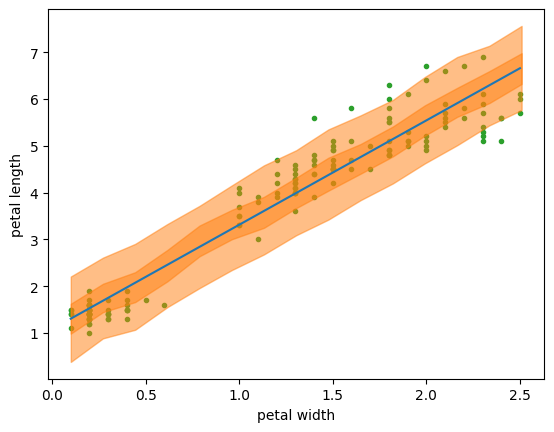

In [25]:

#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_li.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
petal_width = np.random.normal(iris.petal_width.values, 0.01)
idx = np.argsort(petal_width)
x = np.linspace(petal_width.min(), petal_width.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_li.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(petal_width[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(iris.petal_width, iris.petal_length, "C2.", zorder=-3)
ax.plot(iris.petal_width[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("petal width")
ax.set_ylabel("petal length")


 The graph shows a positive linear relationship between petal width and petal length: as petal width increases, petal length also increases. The blue line represents the line of best fit, showing the model's prediction for this trend. The orange shaded areas capture the uncertainty in these predictions, with the green dots mostly falling within the intervals, especially the wider 94% HDI. The model mostly captures the pattern in the data, while still accounting for some variability in petal lengths at given petal widths.

<Axes: xlabel='y_pred'>

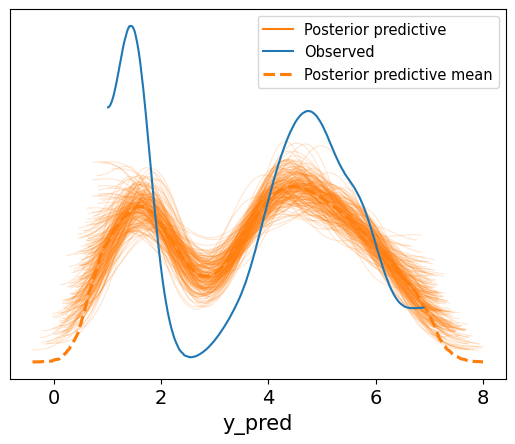

In [28]:
#posterior predictive check
az.plot_ppc(idata_li, num_pp_samples=200, colors=["C1", "C0", "C1"])

 This graph shows that the model does not do a great job of matching the data. The orange lines and dashed line give a smooth prediction, but they miss the sharp ups and downs in the blue observed line. The model seems too simple and ignores the weird patterns in the data. While the predictions follow the general shape, they fail to capture the real details, showing the model might not fully understand the data.

<Axes: ylabel='petal_length'>

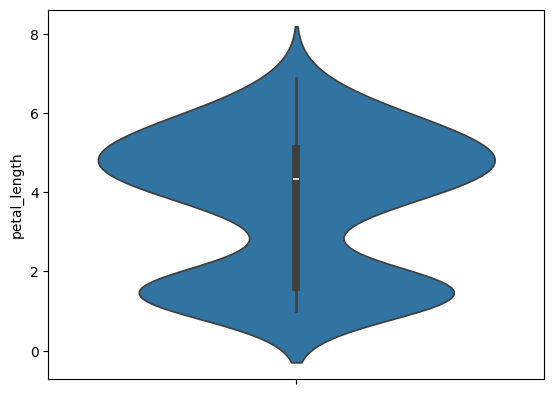

In [29]:
sns.violinplot(iris.petal_length)

In [30]:
import pymc as pm
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the Iris dataset
from sklearn.datasets import load_iris
data = load_iris(as_frame=True)
iris = data.frame

# Add species index
le = LabelEncoder()
iris["species_idx"] = le.fit_transform(iris["target"])  # Encode species as 0, 1, 2
species = le.classes_

# Define coordinate system
iris_coords = {"species": species}

# PyMC Model
with pm.Model(coords=iris_coords) as h_model:
    # Hyper-priors
    α_μ = pm.Normal("α_μ", mu=iris["sepal length (cm)"].mean(), sigma=3)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=3)
    β_σ = pm.HalfNormal("β_σ", 5)

    # Priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="species")
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="species")
    σ = pm.HalfNormal("σ", 5)

    # Likelihood
    # Linear relationship between petal length and petal width by species
    species_idx = iris["species_idx"].values
    y = pm.Normal(
        "y_pred",
        mu=α[species_idx] + β[species_idx] * iris["petal width (cm)"],
        sigma=σ,
        observed=iris["petal length (cm)"]
    )

    # Sampling
    idata_h_b = pm.sample(target_accept=0.99)


Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


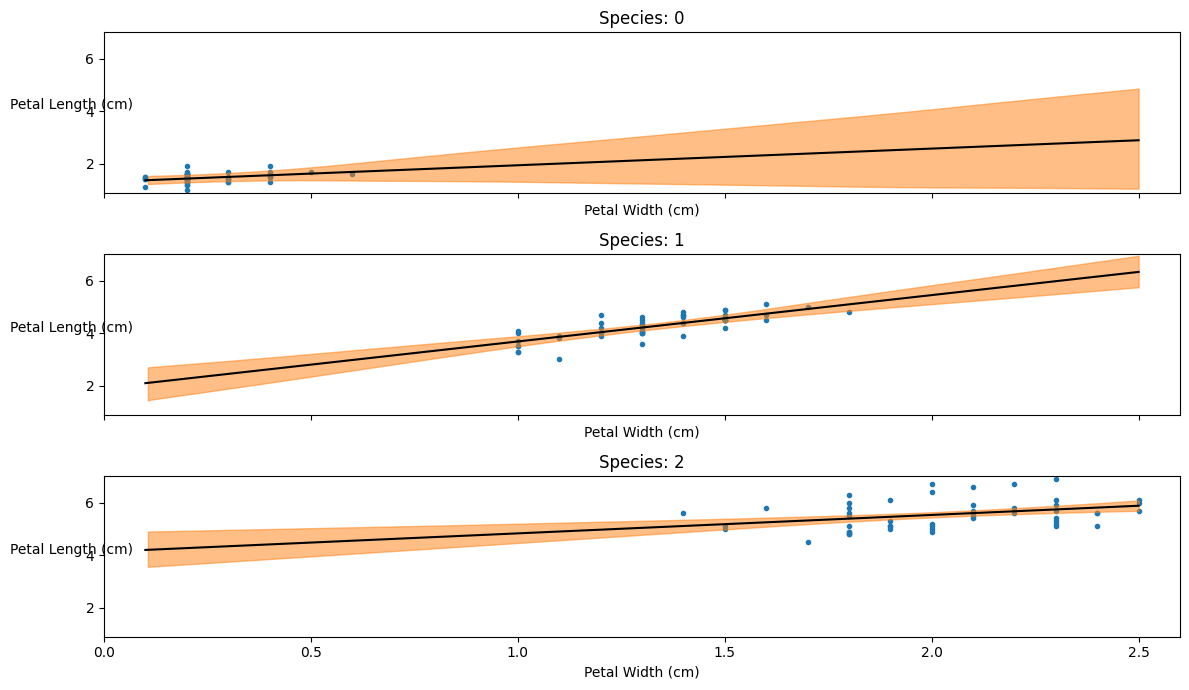

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import xarray as xr

#Set up plots
_, ax = plt.subplots(3, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)

# xvalues for plotting the linear equation
x_range = np.linspace(iris["petal width (cm)"].min(), iris["petal width (cm)"].max(), 10)

# Grab the posterior from the inference data
posterior = az.extract(idata_h_b)

# Plot all lines against the data
for i, species in enumerate(le.classes_):
    # Plot raw data for each species
    species_data = iris[iris["species_idx"] == i]
    ax[i].scatter(
        x=species_data["petal width (cm)"],
        y=species_data["petal length (cm)"],
        marker="."
    )
    # Titles and labels
    ax[i].set_title(f"Species: {species}")
    ax[i].set_xlabel("Petal Width (cm)")
    ax[i].set_ylabel("Petal Length (cm)", labelpad=10, rotation=0)

    # Grab posterior info
    alphas = posterior["α"].sel(species=i)
    betas = posterior["β"].sel(species=i)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    # Plot the posterior mean line
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    # Plot the 94% HDI (Highest Density Interval)
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    # Set window size
    plt.xlim(iris["petal width (cm)"].min() - 0.1, iris["petal width (cm)"].max() + 0.1)
    plt.ylim(iris["petal length (cm)"].min() - 0.1, iris["petal length (cm)"].max() + 0.1)

# Show the plot
plt.tight_layout()
plt.show()


These graphs show how petal width and petal length are related for three different iris species (Species 0, 1,and 2). The graphs are split by species to make it easier to see how the relationship changes for each one. For Species 0 ( top graph), the data points are clustered at smaller values, and the black line showing the trend is almost flat, meaning there’s little or no relationship between petal width and petal length. The orange shaded area is wide, showing a lot of uncertainty. For Species 1 (middle graph), the points are more spread out, and there’s a clear piositive relationship between petal width and petal length, with the black line sloping upward and the confidence area being narrow, meaning the model is more certain about the trend. For Species 2 (bottom graph), the data points are even more spread out, and while there’s still a positive relationship, the slope of the black line is flatter than in Species 1. The confideince area here is wider than for Species 1 but smaller than for Species 0, showing moderate uncertainty. Splitting the graphs by species helps us see that the relationship between petal width and petal length is weak for Species 0, strong for Species 1, and more spread out but still positive for Species 2. Oversimplifying the data lets us capture the different patterns for each species.

Output()

Output()

Output()

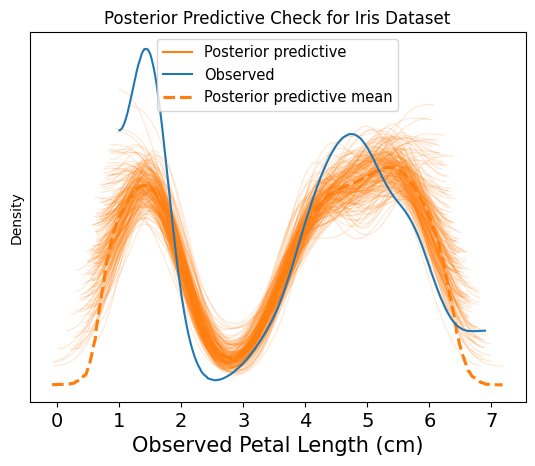

In [32]:
# PyMC Model
with pm.Model(coords=iris_coords) as h_model:
    # Hyper-priors
    α_μ = pm.Normal("α_μ", mu=iris["sepal length (cm)"].mean(), sigma=3)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=3)
    β_σ = pm.HalfNormal("β_σ", 5)

    # Priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="species")
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="species")
    σ = pm.HalfNormal("σ", 5)

    # Likelihood
    # Linear relationship between petal length and petal width by species
    species_idx = iris["species_idx"].values
    y = pm.Normal(
        "y_pred",
        mu=α[species_idx] + β[species_idx] * iris["petal width (cm)"],
        sigma=σ,
        observed=iris["petal length (cm)"]
    )

    # Sampling
    idata_h_b = pm.sample(target_accept=0.99) #<-- here is the original inference data object

# Generate posterior predictive samples, notice we pass h_model
ppc = pm.sample_posterior_predictive(idata_h_b, model=h_model)

# Update idata_h_b with posterior predictive samples
idata_h_b.extend(ppc)

# Posterior Predictive Check
az.plot_ppc(
    idata_h_b,
    num_pp_samples=200,  # Number of posterior predictive samples to include in the plot
    colors=["C1", "C0", "C1"],  # Colors for visualizing observed vs predicted data
)
plt.title("Posterior Predictive Check for Iris Dataset")
plt.xlabel("Observed Petal Length (cm)")
plt.ylabel("Density")
plt.show()

The model does a much better job because the orange prediction lines closely follow the shape of the blue line, which represents the real data. This means the model can accurately capture the patterns in the observed petal length, such as the two peaks around 1.5 cm and 5 cm. The graph is better than earlier one because it clearly shows not only the overall trend but also the variation in predictions through the many thin orange lines. These lines help us see how consistent the model is with the real data and give us an idea of the model's uncertainty. This level of detail makes it easier to judge how reliable and accurate the model is.